# CIFAR-10 Classification PyTorch

## Imports


In [ ]:
import ssl
from pathlib import Path
import certifi

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split

In [2]:
ssl._create_default_https_context = lambda: ssl.create_default_context(
    cafile=certifi.where()
)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

## Config


In [4]:
CONFIG = {
    "seed": 42,
    "data_root": "../data",
    "batch_size": 128,
    "epochs": 30,
    "lr": 0.03,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "val_ratio": 0.1,
    "num_workers": 0,
    "augment": True,
    "label_smoothing": 0.1,
    "patience": 8,
    "train_mode": "both",  # options: "basic", "v2", "both"
    "analysis_model": "cnnv2",
    "checkpoint_dir": "checkpoints",
    "reports_dir": "reports",
}

set_seed(CONFIG["seed"])
device = get_device()

CHECKPOINT_DIR = Path(CONFIG["checkpoint_dir"])
REPORTS_DIR = Path(CONFIG["reports_dir"])
FIGURES_DIR = REPORTS_DIR / "figures"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Device:", device)
print("PyTorch:", torch.__version__)

Device: mps
PyTorch: 2.10.0


## EDA


In [ ]:
raw_train = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=True, download=True
)
raw_test = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=False, download=True
)

class_names = raw_train.classes
train_targets = np.array(raw_train.targets)

print(f"Train samples: {len(raw_train)}")
print(f"Test samples: {len(raw_test)}")
print("Classes:", class_names)

/Users/albertopuliga/Desktop/Coding/CIFAR10-Pytorch/.venv/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Train samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
counts = pd.Series(train_targets).value_counts().sort_index()
for idx, count in enumerate(counts.values):
    print(f"{class_names[idx]:<12} {count}")

airplane     5000
automobile   5000
bird         5000
cat          5000
deer         5000
dog          5000
frog         5000
horse        5000
ship         5000
truck        5000


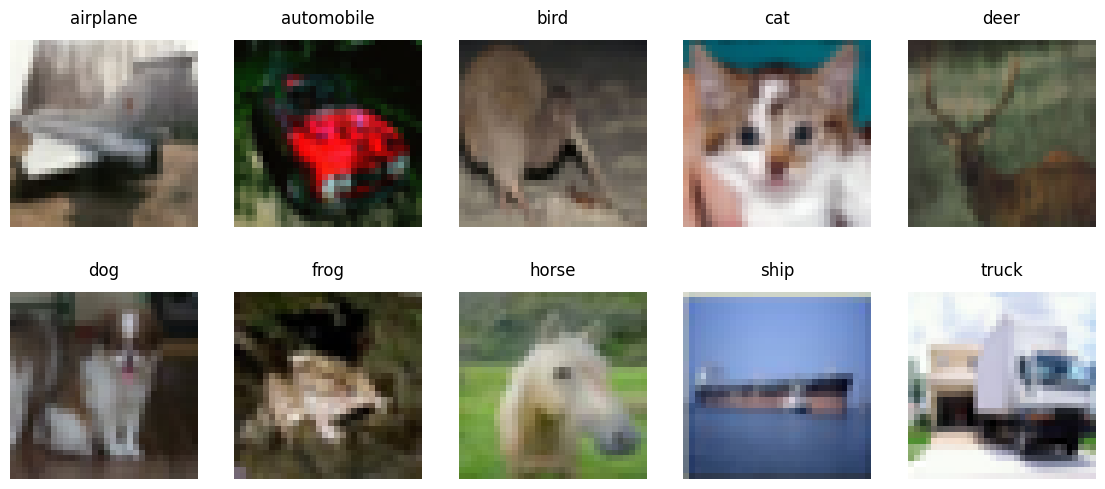

In [ ]:
rng = np.random.default_rng(CONFIG["seed"])
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for class_id, class_name in enumerate(class_names):
    idxs = np.where(train_targets == class_id)[0]
    idx = int(rng.choice(idxs))
    image, _ = raw_train[idx]
    ax = axes[class_id // 5, class_id % 5]
    ax.imshow(image)
    ax.set_title(class_name, pad=12)  # Increase spacing between image and title
    ax.axis("off")

plt.savefig(FIGURES_DIR / "eda_sample_grid.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
stats_ds = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"],
    train=True,
    download=False,
    transform=transforms.ToTensor(),
)
stats_loader = DataLoader(
    stats_ds, batch_size=512, shuffle=False, num_workers=CONFIG["num_workers"]
)

channel_sum = torch.zeros(3)
channel_sum_sq = torch.zeros(3)
num_pixels = 0

for images, _ in stats_loader:
    channel_sum += images.sum(dim=[0, 2, 3])
    channel_sum_sq += (images**2).sum(dim=[0, 2, 3])
    num_pixels += images.size(0) * images.size(2) * images.size(3)

train_mean = (channel_sum / num_pixels).numpy()
train_std = torch.sqrt(
    channel_sum_sq / num_pixels - torch.tensor(train_mean) ** 2
).numpy()

print("Train mean:", train_mean)
print("Train std:", train_std)

/Users/albertopuliga/Desktop/Coding/CIFAR10-Pytorch/.venv/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Train mean: [0.49139965 0.4821585  0.44653103]
Train std: [0.24703231 0.2434849  0.26158765]


## Data Pipeline


### 1. Build Transforms


In [ ]:
train_transforms = []
if CONFIG["augment"]:
    train_transforms.extend(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ]
    )

train_transforms.extend(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist()),
    ]
)

train_transform = transforms.Compose(train_transforms)
eval_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist()),
    ]
)

### 2. Create Datasets


In [17]:
full_train_aug = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=True, download=False, transform=train_transform
)
full_train_eval = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=True, download=False, transform=eval_transform
)
test_ds = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=False, download=False, transform=eval_transform
)

### 3. Split Train/Validation


In [18]:
all_idx = np.arange(len(full_train_aug))
train_idx, val_idx = train_test_split(
    all_idx,
    test_size=CONFIG["val_ratio"],
    random_state=CONFIG["seed"],
    stratify=np.array(full_train_aug.targets),
)

train_ds = Subset(full_train_aug, train_idx)
val_ds = Subset(full_train_eval, val_idx)

### 4. Build DataLoaders


In [ ]:
loader_gen = torch.Generator().manual_seed(CONFIG["seed"])

train_loader = DataLoader(
    train_ds,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    generator=loader_gen,
)
val_loader = DataLoader(
    val_ds,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    generator=loader_gen,
)
test_loader = DataLoader(
    test_ds,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    generator=loader_gen,
)

print(
    f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}"
)

Train: 45000 | Val: 5000 | Test: 10000


## Models


In [20]:
class BaselineCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [21]:
class CNNv2(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.15),
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        return self.head(self.features(x))

In [23]:
def build_model(name: str):
    if name == "baseline":
        return BaselineCNN(len(class_names))
    if name == "cnnv2":
        return CNNv2(len(class_names))
    raise ValueError(f"Unknown model: {name}")

## Training


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    preds_all, targets_all = [], []

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.append(outputs.argmax(dim=1).detach().cpu())
        targets_all.append(targets.detach().cpu())

    preds = torch.cat(preds_all).numpy()
    targets = torch.cat(targets_all).numpy()
    return running_loss / len(loader.dataset), accuracy_score(targets, preds)


def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            preds_all.append(outputs.argmax(dim=1).cpu())
            targets_all.append(targets.cpu())

    preds = torch.cat(preds_all).numpy()
    targets = torch.cat(targets_all).numpy()
    return (
        running_loss / len(loader.dataset),
        accuracy_score(targets, preds),
        targets,
        preds,
    )


def train_model(model_name: str):
    set_seed(CONFIG["seed"])
    model = build_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["label_smoothing"])
    optimizer = optim.SGD(
        model.parameters(),
        lr=CONFIG["lr"],
        momentum=CONFIG["momentum"],
        weight_decay=CONFIG["weight_decay"],
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["epochs"])

    history = []
    best_val_acc = -1.0
    best_epoch = -1
    bad_epochs = 0
    ckpt_path = CHECKPOINT_DIR / f"best_{model_name}.pth"

    print(f"\nTraining {model_name}")

    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, y_val, p_val = eval_epoch(model, val_loader, criterion)

        p, r, f1, _ = precision_recall_fscore_support(
            y_val, p_val, average="macro", zero_division=0
        )
        lr_now = optimizer.param_groups[0]["lr"]

        history.append(
            {
                "model": model_name,
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_precision_macro": p,
                "val_recall_macro": r,
                "val_f1_macro": f1,
                "lr": lr_now,
            }
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            bad_epochs = 0
            torch.save(
                {
                    "model_name": model_name,
                    "model_state_dict": model.state_dict(),
                    "best_val_acc": best_val_acc,
                    "epoch": epoch,
                    "mean": train_mean.tolist(),
                    "std": train_std.tolist(),
                    "class_names": class_names,
                },
                ckpt_path,
            )
        else:
            bad_epochs += 1

        scheduler.step()

        print(
            f"Epoch {epoch:02d}/{CONFIG['epochs']} | "
            f"train_acc={train_acc:.4f} val_acc={val_acc:.4f} | "
            f"train_loss={train_loss:.4f} val_loss={val_loss:.4f}"
        )

        if bad_epochs >= CONFIG["patience"]:
            print(f"Early stopping after {epoch} epochs.")
            break

    return {
        "model": model_name,
        "history": pd.DataFrame(history),
        "best_val_acc": best_val_acc,
        "best_epoch": best_epoch,
        "checkpoint": str(ckpt_path),
    }

In [26]:
mode_to_models = {
    "basic": ["baseline"],
    "v2": ["cnnv2"],
    "both": ["baseline", "cnnv2"],
}

train_mode = str(CONFIG.get("train_mode", "both")).lower()
if train_mode not in mode_to_models:
    raise ValueError(
        f"Unsupported train_mode: {train_mode}. Choose one of {list(mode_to_models.keys())}."
    )

models_to_train = mode_to_models[train_mode]
print(f"Training mode: {train_mode} -> {models_to_train}")

runs = [train_model(name) for name in models_to_train]
runs_by_model = {r["model"]: r for r in runs}

active_model = str(CONFIG.get("analysis_model", models_to_train[0]))
if active_model not in runs_by_model:
    active_model = models_to_train[0]
    print(f"analysis_model not trained in this run. Using: {active_model}")

active_run = runs_by_model[active_model]
active_history = active_run["history"]

training_summary_df = pd.DataFrame(
    [
        {
            "model": r["model"],
            "best_val_acc": r["best_val_acc"],
            "best_epoch": r["best_epoch"],
            "checkpoint": r["checkpoint"],
        }
        for r in runs
    ]
).sort_values("best_val_acc", ascending=False)

training_summary_df

Training mode: both -> ['baseline', 'cnnv2']

Training baseline
Epoch 01/30 | train_acc=0.3184 val_acc=0.4508 | train_loss=1.9281 val_loss=1.6711
Epoch 02/30 | train_acc=0.4644 val_acc=0.5060 | train_loss=1.6601 val_loss=1.6000
Epoch 03/30 | train_acc=0.5161 val_acc=0.5698 | train_loss=1.5592 val_loss=1.4623
Epoch 04/30 | train_acc=0.5616 val_acc=0.6098 | train_loss=1.4743 val_loss=1.3934
Epoch 05/30 | train_acc=0.5849 val_acc=0.6208 | train_loss=1.4274 val_loss=1.3579
Epoch 06/30 | train_acc=0.6054 val_acc=0.6296 | train_loss=1.3880 val_loss=1.3466
Epoch 07/30 | train_acc=0.6148 val_acc=0.6664 | train_loss=1.3650 val_loss=1.2713
Epoch 08/30 | train_acc=0.6330 val_acc=0.6656 | train_loss=1.3316 val_loss=1.2617
Epoch 09/30 | train_acc=0.6430 val_acc=0.6630 | train_loss=1.3096 val_loss=1.2605
Epoch 10/30 | train_acc=0.6538 val_acc=0.6770 | train_loss=1.2853 val_loss=1.2450
Epoch 11/30 | train_acc=0.6613 val_acc=0.6840 | train_loss=1.2678 val_loss=1.2291
Epoch 12/30 | train_acc=0.6689 val

,model,best_val_acc,best_epoch,checkpoint
1,cnnv2,0.9134,30,checkpoints/best_cnnv2.pth
0,baseline,0.7702,29,checkpoints/best_baseline.pth


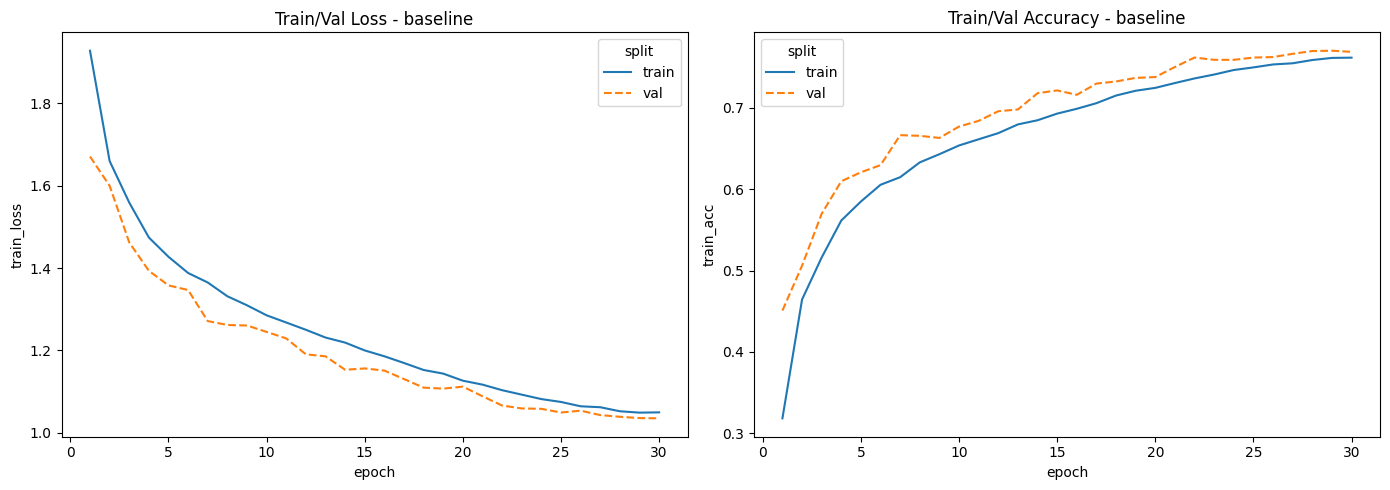

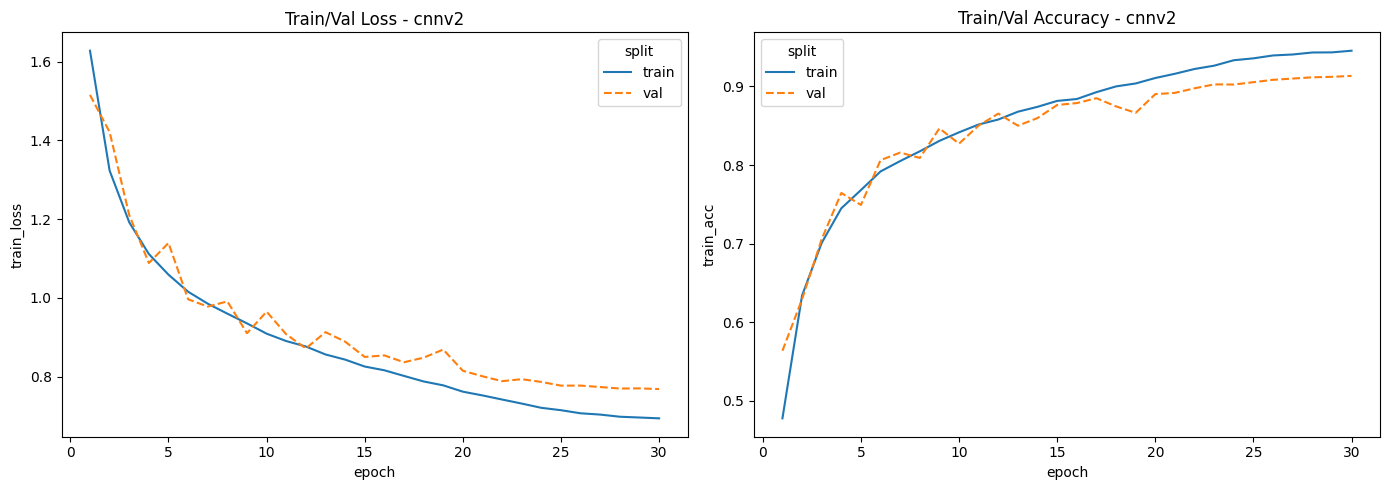

In [27]:
models_for_plots = [r["model"] for r in runs] if len(runs) > 1 else [active_model]

for model_name in models_for_plots:
    history = runs_by_model[model_name]["history"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=history, x="epoch", y="train_loss", ax=axes[0], label="train")
    sns.lineplot(
        data=history,
        x="epoch",
        y="val_loss",
        ax=axes[0],
        linestyle="--",
        label="val",
    )
    axes[0].set_title(f"Train/Val Loss - {model_name}")
    axes[0].legend(title="split")

    sns.lineplot(data=history, x="epoch", y="train_acc", ax=axes[1], label="train")
    sns.lineplot(
        data=history,
        x="epoch",
        y="val_acc",
        ax=axes[1],
        linestyle="--",
        label="val",
    )
    axes[1].set_title(f"Train/Val Accuracy - {model_name}")
    axes[1].legend(title="split")

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"training_curves_{model_name}.png", dpi=150)
    plt.show()


## Evaluation


In [ ]:
def collect_predictions(model, loader):
    model.eval()
    y_true, y_pred, y_prob, imgs = [], [], [], []

    with torch.no_grad():
        for images, targets in loader:
            out = model(images.to(device))
            prob = torch.softmax(out, dim=1)
            pred = prob.argmax(dim=1)
            y_true.append(targets.cpu())
            y_pred.append(pred.cpu())
            y_prob.append(prob.cpu())
            imgs.append(images.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()
    images = torch.cat(imgs)
    confidence = y_prob.max(axis=1)
    return y_true, y_pred, y_prob, confidence, images


eval_rows = []
eval_cache = {}

for run in runs:
    model_name = run["model"]
    ckpt = torch.load(run["checkpoint"], map_location=device)
    model = build_model(model_name).to(device)
    model.load_state_dict(ckpt["model_state_dict"])

    y_true, y_pred, y_prob, confidence, images = collect_predictions(model, test_loader)
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    eval_rows.append(
        {
            "model": model_name,
            "test_accuracy": acc,
            "test_precision_macro": p,
            "test_recall_macro": r,
            "test_f1_macro": f1,
        }
    )

    eval_cache[model_name] = {
        "model": model_name,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "confidence": confidence,
        "images": images,
        "cm": cm,
        "per_class_acc": per_class_acc,
    }

selected = eval_cache[active_model]
evaluated_model = selected["model"]

results_df = pd.DataFrame(eval_rows).sort_values("test_accuracy", ascending=False)
results_df

,model,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
1,cnnv2,0.9056,0.905347,0.9056,0.905223
0,baseline,0.7717,0.769869,0.7717,0.770294


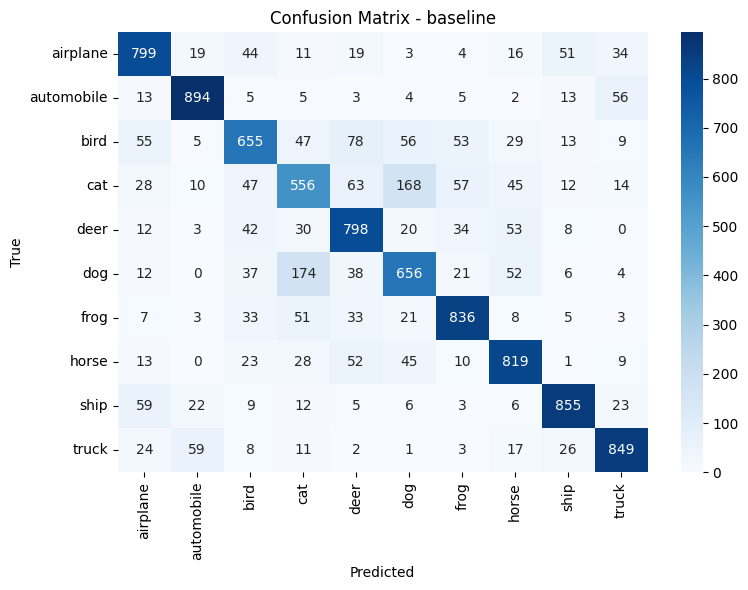

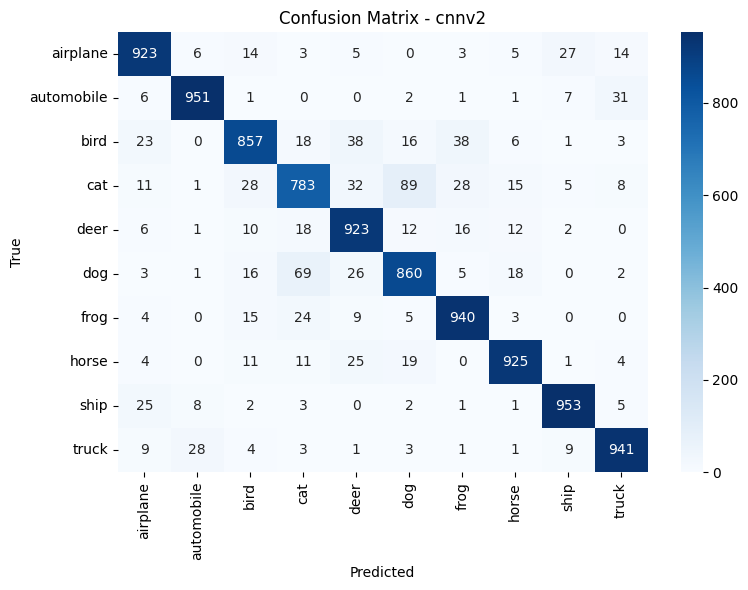

,model,class,accuracy
1,baseline,automobile,0.894
8,baseline,ship,0.855
9,baseline,truck,0.849
6,baseline,frog,0.836
7,baseline,horse,0.819
0,baseline,airplane,0.799
4,baseline,deer,0.798
5,baseline,dog,0.656
2,baseline,bird,0.655
3,baseline,cat,0.556


In [ ]:
models_for_cm = [r["model"] for r in runs] if len(runs) > 1 else [evaluated_model]
per_class_tables = []

for model_name in models_for_cm:
    cm = eval_cache[model_name]["cm"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"confusion_matrix_{model_name}.png", dpi=150)
    plt.show()

    per_class_tables.append(
        pd.DataFrame(
            {
                "model": model_name,
                "class": class_names,
                "accuracy": eval_cache[model_name]["per_class_acc"],
            }
        )
    )

per_class_accuracy_df = pd.concat(per_class_tables, ignore_index=True)
per_class_accuracy_df.sort_values(["model", "accuracy"], ascending=[True, False])

## Error Analysis


In [ ]:
def denorm(x):
    img = x.numpy().transpose(1, 2, 0)
    img = img * train_std.reshape(1, 1, 3) + train_mean.reshape(1, 1, 3)
    return np.clip(img, 0, 1)


y_true = selected["y_true"]
y_pred = selected["y_pred"]
conf = selected["confidence"]
images = selected["images"]

errors = np.where(y_true != y_pred)[0]
conf_errors = errors[np.argsort(conf[errors])[::-1]]

print(f"Total errors ({evaluated_model}): {len(errors)}")
print("Top 10 confident mistakes:")
for idx in conf_errors[:10]:
    print(
        f"idx={idx:4d} | true={class_names[y_true[idx]]:>10s} | "
        f"pred={class_names[y_pred[idx]]:>10s} | conf={conf[idx]:.3f}"
    )

Total errors (cnnv2): 944
Top 10 confident mistakes:
idx=9227 | true=automobile | pred=     truck | conf=0.987
idx=2705 | true=      ship | pred=  airplane | conf=0.980
idx=2405 | true=       cat | pred=      frog | conf=0.977
idx=7099 | true=       cat | pred=       dog | conf=0.969
idx=8542 | true=      bird | pred=       cat | conf=0.961
idx=8521 | true=     truck | pred=      ship | conf=0.961
idx=5881 | true=       cat | pred=       dog | conf=0.961
idx=5511 | true=       cat | pred=      frog | conf=0.955
idx=2542 | true=      bird | pred=  airplane | conf=0.953
idx=4302 | true=      bird | pred=       dog | conf=0.952


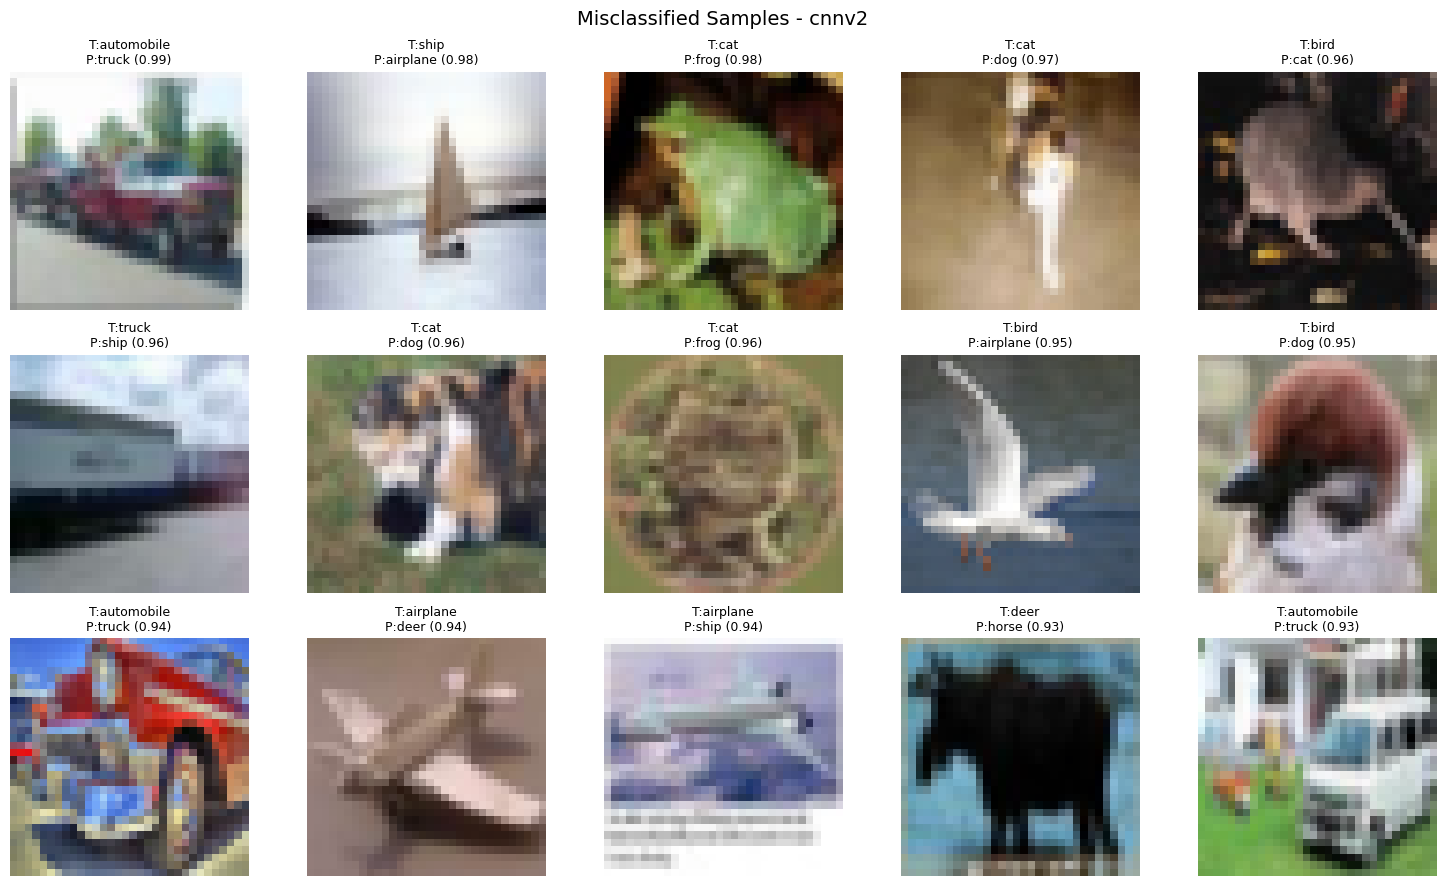

In [ ]:
show_n = 15
pick = conf_errors[:show_n]
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for ax, idx in zip(axes, pick):
    ax.imshow(denorm(images[idx]))
    ax.set_title(
        f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred[idx]]} ({conf[idx]:.2f})",
        fontsize=9,
    )

plt.suptitle(f"Misclassified Samples - {evaluated_model}", fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f"misclassified_{evaluated_model}.png", dpi=150)
plt.show()

In [ ]:
results_df.to_csv(REPORTS_DIR / "results.csv", index=False)
results_df.to_json(REPORTS_DIR / "results.json", orient="records", indent=2)
print("Saved results to reports/results.csv and reports/results.json")
results_df

Saved results to reports/results.csv and reports/results.json


,model,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
1,cnnv2,0.9056,0.905347,0.9056,0.905223
0,baseline,0.7717,0.769869,0.7717,0.770294
